# Pytorch_1.1_regression  [WorldHappinessReport]

### <span style="color:purple"> Tworzenie małych prototypów o pełnej zdolności bojowej

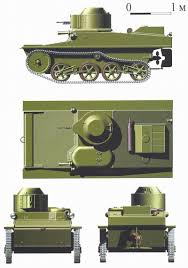

### <span style="color:blue"> Cele:
    1. podstawić prawdziwy plik danych
    2. przeliczyć zapamiętać model odpalić model
    3. zweryfikowac model czy liczy dla innych danych
    4. Cel extra - zrobić waluację modelu 





https://github.com/jcjohnson/pytorch-examples#pytorch-custom-nn-modules
10:10  10:50
11:05  

W powyższych przykładach musieliśmy ręcznie wdrożyć zarówno przejścia do przodu, jak i do tyłu naszej sieci neuronowej. Ręczne wdrożenie wstecznego przejścia nie jest wielkim problemem dla małej sieci dwuwarstwowej, ale może szybko stać się bardzo kłopotliwe dla dużych złożonych sieci.

In [1]:
import torch
import torch.nn as nn

### Odpalam karte graficzną GPU
Sprawdzamy czy procesy CUDA istnieją w procesie

In [2]:
torch.cuda.is_available()

True

In [37]:
#device = torch.device('cpu') # obliczenia robie na CPU
device = torch.device('cuda') # obliczenia robie na GPU

In [38]:
device

device(type='cuda')

In [4]:
import pandas as pd

df = pd.read_csv('/home/wojciech/Pulpit/1/WorldHappinessReport.csv')
df.head(3)

,Unnamed: 0,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,0,Afghanistan,Southern Asia,153.0,3.575,0.31982,0.30285,0.30335,0.23414,0.09719,0.36510,1.95210,2015.0
1,1,Albania,Central and Eastern Europe,95.0,4.959,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894,2015.0
2,2,Algeria,Middle East and Northern Africa,68.0,5.605,0.93929,1.07772,0.61766,0.28579,0.17383,0.07822,2.43209,2015.0


In [5]:
N, D_in, H, D_out = 64, 1000, 100, 10

Powyżej zostały określone parametry aby tensor zmiennych niezależnych i tensor wynikowy były odpowiednie 

x: 64 obserwacji i 1000 zmiennych

y: 64 obserwacji i 10 zmiennych

### <span style="color:blue">2. Usuwanie pustych komórek NaN </span>
Sieci nieuronowe nie lubiś pustych komórek NaN -jak tego nie zrobimy wyjdzie nam NaN

In [6]:
df = df.dropna(how ='any')
df.isnull().sum()

Unnamed: 0                       0
Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
Year                             0
dtype: int64

### Tworzy losowe dane wejściowe i wyjściowe 

In [7]:
X = torch.tensor((df['Economy (GDP per Capita)'],df['Freedom'],df['Trust (Government Corruption)']), dtype=torch.float)
X

tensor([[0.3198, 0.8787, 0.9393,  ..., 0.5917, 0.6364, 0.3758],
        [0.2341, 0.3573, 0.2858,  ..., 0.2495, 0.4616, 0.3364],
        [0.0972, 0.0641, 0.1738,  ..., 0.0568, 0.0782, 0.0954]])

#### <span style="color:blue"> 3.1 TRansponuje wektor zmiennych niezależnych aby stał się kolumną</span>

In [8]:
X = torch.transpose(X.flip(0),0,1)
X

tensor([[0.0972, 0.2341, 0.3198],
        [0.0641, 0.3573, 0.8787],
        [0.1738, 0.2858, 0.9393],
        ...,
        [0.0568, 0.2495, 0.5917],
        [0.0782, 0.4616, 0.6364],
        [0.0954, 0.3364, 0.3758]])

### <span style="color:blue">4. Przekształcanie na tensor zmiennych zależnych</span>
Jako dane wynikowe wybrano zmienną: 'Happiness Score'

In [9]:
y = torch.tensor((df['Happiness Score']), dtype=torch.float)
#y

#### <span style="color:blue"> 4.1 TRansponuje wektor wynikowy aby stał się kolumną</span>

In [10]:
y = y.view(y.shape[0],1)
y[:12]

tensor([[3.5750],
        [4.9590],
        [5.6050],
        [4.0330],
        [6.5740],
        [4.3500],
        [7.2840],
        [7.2000],
        [5.2120],
        [5.9600],
        [4.6940],
        [5.8130]])

In [11]:
print('X ',X.size())
print('y ',y.size())

X  torch.Size([469, 3])
y  torch.Size([469, 1])


### Tworzy wagi losowe dla x i y

In [12]:
N, D_in = X.shape
N, D_out = y.shape

In [13]:
H = 10
device = torch.device('cpu')

In [14]:
w1 = torch.randn(D_in, H, device=device)
w2 = torch.randn(H, D_out, device=device)

In [15]:
w1[:2]

tensor([[ 1.3534, -0.1128,  0.2995,  0.5296,  1.1518, -0.2355,  0.2037,  0.1067,
          0.4584,  0.6803],
        [-0.8240, -1.1213,  0.1785,  0.3114, -0.0172,  0.9672, -0.2457,  1.8667,
          0.5038, -2.1726]])

In [16]:
print('w1 dla x: ', w1.shape)
print('w2 dla y: ', w2.shape)

w1 dla x:  torch.Size([3, 10])
w2 dla y:  torch.Size([10, 1])


### Definiowanie nauki - NAUKA MODELU

In [17]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu



epochs = 2500
aggregated_losses = []


learning_rate = 0.0001     #<= wielkość kroków
for t in range(epochs):         #<= ilość epok
 
  h = X.mm(w1)               #<= zwykłe mnożenie macierzy x*w1
  h_relu = h.clamp(min=0)    #<= wyznaczenie ograniczenia do min=0
  y_pred = h_relu.mm(w2)     #<= pomnożenie przez daje predykcję y_pred
## Wyznaczenie straty (loss) jako wskaźnika r2
## Strata Loss jest skalarem i jest przechowywana w tensorze PyTorcha(); 
## możemy uzyskać jego wartość jako liczbę w języku Python za pomocą loss.item ().
  loss = (y_pred - y).pow(2).sum()
  
  aggregated_losses.append(loss) ## potrzebne do wykresu

  print('Krok:',t, loss.item())        # Dla każdej pentli drukuje wynik r2
  # Backprop do obliczania gradientów w1 i w2 w odniesieniu do strat
  grad_y_pred = 2.0 * (y_pred - y)      #błąd modelu razy 2
  grad_w2 = h_relu.t().mm(grad_y_pred)  #
  grad_h_relu = grad_y_pred.mm(w2.t())
  grad_h = grad_h_relu.clone()
  grad_h[h < 0] = 0
  grad_w1 = X.t().mm(grad_h)

  # Zaktualizuj wagi przy użyciu spadku gradientu
  w1 -= learning_rate * grad_w1
  w2 -= learning_rate * grad_w2


print('minutes: ',
(time.time() - start_time)/60) ## koniec pomiaru czasu


Krok: 0 6384.34130859375
Krok: 1 1965.818115234375
Krok: 2 1003.153076171875
Krok: 3 958.1796264648438
Krok: 4 925.4003295898438
Krok: 5 894.9331665039062
Krok: 6 866.6587524414062
Krok: 7 840.2391357421875
Krok: 8 815.6593017578125
Krok: 9 792.748046875
Krok: 10 771.311279296875
Krok: 11 751.216552734375
Krok: 12 732.419677734375
Krok: 13 714.8140869140625
Krok: 14 698.3189697265625
Krok: 15 682.8720092773438
Krok: 16 668.4288940429688
Krok: 17 654.9102172851562
Krok: 18 642.2513427734375
Krok: 19 630.400390625
Krok: 20 619.2946166992188
Krok: 21 608.8944091796875
Krok: 22 599.14697265625
Krok: 23 589.990234375
Krok: 24 581.394287109375
Krok: 25 573.3160400390625
Krok: 26 565.7098999023438
Krok: 27 558.540771484375
Krok: 28 551.7998046875
Krok: 29 545.4324340820312
Krok: 30 539.4053344726562
Krok: 31 533.6759643554688
Krok: 32 528.1941528320312
Krok: 33 522.9649658203125
Krok: 34 517.9777221679688
Krok: 35 513.1998291015625
Krok: 36 508.6441650390625
Krok: 37 504.2728576660156
Krok: 3

Krok: 439 382.3177185058594
Krok: 440 382.29718017578125
Krok: 441 382.2766418457031
Krok: 442 382.2547607421875
Krok: 443 382.2332763671875
Krok: 444 382.2119445800781
Krok: 445 382.1907958984375
Krok: 446 382.1697998046875
Krok: 447 382.14892578125
Krok: 448 382.1281433105469
Krok: 449 382.1075439453125
Krok: 450 382.0868225097656
Krok: 451 382.06585693359375
Krok: 452 382.044921875
Krok: 453 382.0241394042969
Krok: 454 382.00341796875
Krok: 455 381.98260498046875
Krok: 456 381.9619140625
Krok: 457 381.94122314453125
Krok: 458 381.920654296875
Krok: 459 381.9001770019531
Krok: 460 381.8797302246094
Krok: 461 381.85931396484375
Krok: 462 381.8390197753906
Krok: 463 381.8187255859375
Krok: 464 381.7985534667969
Krok: 465 381.77838134765625
Krok: 466 381.7582092285156
Krok: 467 381.7394714355469
Krok: 468 381.72222900390625
Krok: 469 381.7010498046875
Krok: 470 381.68084716796875
Krok: 471 381.6607666015625
Krok: 472 381.6441955566406
Krok: 473 381.6264953613281
Krok: 474 381.6044006347

Krok: 740 378.24713134765625
Krok: 741 378.2397155761719
Krok: 742 378.2297668457031
Krok: 743 378.220703125
Krok: 744 378.2120666503906
Krok: 745 378.1971740722656
Krok: 746 378.18536376953125
Krok: 747 378.1705322265625
Krok: 748 378.1605529785156
Krok: 749 378.1470031738281
Krok: 750 378.1378173828125
Krok: 751 378.12518310546875
Krok: 752 378.1163024902344
Krok: 753 378.1044006347656
Krok: 754 378.09552001953125
Krok: 755 378.0841369628906
Krok: 756 378.07513427734375
Krok: 757 378.0645446777344
Krok: 758 378.0554504394531
Krok: 759 378.04425048828125
Krok: 760 378.03424072265625
Krok: 761 378.0238037109375
Krok: 762 378.01348876953125
Krok: 763 378.00372314453125
Krok: 764 377.99310302734375
Krok: 765 377.98394775390625
Krok: 766 377.9730224609375
Krok: 767 377.96441650390625
Krok: 768 377.95318603515625
Krok: 769 377.945068359375
Krok: 770 377.9334716796875
Krok: 771 377.9256591796875
Krok: 772 377.9139099121094
Krok: 773 377.9064025878906
Krok: 774 377.8947448730469
Krok: 775 37

Krok: 1222 374.0147705078125
Krok: 1223 374.0096130371094
Krok: 1224 374.0044860839844
Krok: 1225 373.9994201660156
Krok: 1226 373.99432373046875
Krok: 1227 373.9892883300781
Krok: 1228 373.9842529296875
Krok: 1229 373.97918701171875
Krok: 1230 373.97412109375
Krok: 1231 373.96893310546875
Krok: 1232 373.9640197753906
Krok: 1233 373.9588928222656
Krok: 1234 373.9537658691406
Krok: 1235 373.94891357421875
Krok: 1236 373.94378662109375
Krok: 1237 373.938720703125
Krok: 1238 373.93377685546875
Krok: 1239 373.9287109375
Krok: 1240 373.9236755371094
Krok: 1241 373.9187927246094
Krok: 1242 373.9137878417969
Krok: 1243 373.90875244140625
Krok: 1244 373.9036865234375
Krok: 1245 373.8988037109375
Krok: 1246 373.8938903808594
Krok: 1247 373.8887634277344
Krok: 1248 373.8839416503906
Krok: 1249 373.87896728515625
Krok: 1250 373.87396240234375
Krok: 1251 373.8690185546875
Krok: 1252 373.86407470703125
Krok: 1253 373.859130859375
Krok: 1254 373.8541259765625
Krok: 1255 373.8492736816406
Krok: 1256 

Krok: 1519 372.65838623046875
Krok: 1520 372.6539611816406
Krok: 1521 372.64947509765625
Krok: 1522 372.6451110839844
Krok: 1523 372.6407165527344
Krok: 1524 372.6363830566406
Krok: 1525 372.6319274902344
Krok: 1526 372.6275634765625
Krok: 1527 372.6230773925781
Krok: 1528 372.61865234375
Krok: 1529 372.6142578125
Krok: 1530 372.60992431640625
Krok: 1531 372.6054382324219
Krok: 1532 372.6010437011719
Krok: 1533 372.5967102050781
Krok: 1534 372.5923156738281
Krok: 1535 372.587890625
Krok: 1536 372.58343505859375
Krok: 1537 372.5785827636719
Krok: 1538 372.5738830566406
Krok: 1539 372.5691223144531
Krok: 1540 372.5641784667969
Krok: 1541 372.5594177246094
Krok: 1542 372.5547180175781
Krok: 1543 372.5500183105469
Krok: 1544 372.5450744628906
Krok: 1545 372.54034423828125
Krok: 1546 372.5355224609375
Krok: 1547 372.5307922363281
Krok: 1548 372.5259094238281
Krok: 1549 372.5211181640625
Krok: 1550 372.5163269042969
Krok: 1551 372.5115661621094
Krok: 1552 372.50677490234375
Krok: 1553 372.50

Krok: 1997 370.3414001464844
Krok: 1998 370.339599609375
Krok: 1999 370.3352355957031
Krok: 2000 370.3313293457031
Krok: 2001 370.32763671875
Krok: 2002 370.3238525390625
Krok: 2003 370.32012939453125
Krok: 2004 370.31646728515625
Krok: 2005 370.3128967285156
Krok: 2006 370.311279296875
Krok: 2007 370.3067626953125
Krok: 2008 370.30291748046875
Krok: 2009 370.2992248535156
Krok: 2010 370.2955627441406
Krok: 2011 370.29180908203125
Krok: 2012 370.2881164550781
Krok: 2013 370.2846984863281
Krok: 2014 370.28289794921875
Krok: 2015 370.278564453125
Krok: 2016 370.2746887207031
Krok: 2017 370.2709045410156
Krok: 2018 370.2672424316406
Krok: 2019 370.26361083984375
Krok: 2020 370.2598876953125
Krok: 2021 370.2568054199219
Krok: 2022 370.2546081542969
Krok: 2023 370.250244140625
Krok: 2024 370.24652099609375
Krok: 2025 370.2427673339844
Krok: 2026 370.2389831542969
Krok: 2027 370.2353820800781
Krok: 2028 370.2317199707031
Krok: 2029 370.2288818359375
Krok: 2030 370.2264404296875
Krok: 2031 37

Krok: 2308 369.1383972167969
Krok: 2309 369.1344909667969
Krok: 2310 369.1307373046875
Krok: 2311 369.126953125
Krok: 2312 369.1232604980469
Krok: 2313 369.11962890625
Krok: 2314 369.1158752441406
Krok: 2315 369.11224365234375
Krok: 2316 369.1080627441406
Krok: 2317 369.10394287109375
Krok: 2318 369.0999450683594
Krok: 2319 369.0959777832031
Krok: 2320 369.0920104980469
Krok: 2321 369.0881652832031
Krok: 2322 369.0844421386719
Krok: 2323 369.08062744140625
Krok: 2324 369.07684326171875
Krok: 2325 369.072998046875
Krok: 2326 369.0693664550781
Krok: 2327 369.0655517578125
Krok: 2328 369.0618591308594
Krok: 2329 369.0582580566406
Krok: 2330 369.0545349121094
Krok: 2331 369.0507507324219
Krok: 2332 369.0470275878906
Krok: 2333 369.0433349609375
Krok: 2334 369.0396423339844
Krok: 2335 369.0359802246094
Krok: 2336 369.03228759765625
Krok: 2337 369.0286560058594
Krok: 2338 369.0250244140625
Krok: 2339 369.0213928222656
Krok: 2340 369.0177307128906
Krok: 2341 369.0140686035156
Krok: 2342 369.0

CPU minutes:  0.030119669437408448

GPU minutes:  0.03073896567026774

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

### Prognoza na podstawie modelu
- poprostu podstawiamy te same równania które były w modelu 
- Poniższy wynik loss pokazuje ostatnią sekwencje modelu
- Loss pokazuuje ile myli się model (loss = suma kwadratu błedów) po ostatniej sekwencji uczenia się 

In [19]:
with torch.no_grad():
    y_pred = h_relu.mm(w2)  
    loss = (y_pred - y).pow(2).sum()

    print(f'Loss train_set: {loss:.8f}')

Loss train_set: 368.46170044


Ponieważ ustaliliśmy, że nasza warstwa wyjściowa będzie zawierać 1 neuron, każda prognoza będzie zawierać 1 wartości. Przykładowo pierwsze 5 przewidywanych wartości wygląda następująco:

In [20]:
y_pred[:5]

tensor([[2.4534],
        [4.3754],
        [4.2717],
        [3.5406],
        [5.4199]])

Celem takich prognoz jest to, że jeśli rzeczywisty wynik wynosi 0, wartość przy indeksie 0 powinna być wyższa niż wartość przy indeksie 1 i odwrotnie. Możemy pobrać indeks największej wartości z listy za pomocą następującego skryptu:

- np.argmax - Zwraca wskaźniki wartości maksymalnych wzdłuż osi.

<span style="color:red"> NIC Z TEGO NIE ROZUMIEM

In [21]:
import numpy as np
y_pred2 = np.argmax(y_pred, axis=1)
y_pred2[:6]

tensor([0, 0, 0, 0, 0, 0])

Powyższe równanie zwraca wskaźniki wartości maksymalnych wzdłuż osi. 

Ponieważ na liście pierwotnie przewidywanych wyników y_pred dla pierwszych pięciu rekordów wartości przy zerowych indeksach są większe niż wartości przy pierwszych indeksach, możemy zobaczyć 0 w pierwszych pięciu wierszach przetworzonych danych wyjściowych.

In [22]:
y_pred[:4]

tensor([[2.4534],
        [4.3754],
        [4.2717],
        [3.5406]])

### Zapisujemy cały model
TA siec jest tak prosta, że nie można zrobić jej zapisu - bo nie ma zapisanej swojej definicji 

## Użycie bojowe modelu
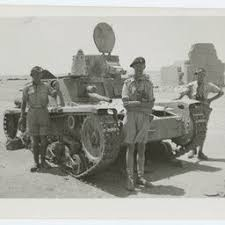



### Podstawiając inne zmienne niezależne można uzyskać wektor zmiennych wyjściowych
Wybieramy sobie jakąś losowy rekord 1% naszej polulacji

In [23]:
df2 = df.sample(frac = 0.01, random_state=10) 
print(df2.shape)
print()
df2


(5, 13)



,Unnamed: 0,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
315,315,Tunisia,Middle East and Northern Africa,98.0,5.045,0.97724,0.43165,0.59577,0.23553,0.08170,0.03936,2.68413,2016.0
149,149,Trinidad And Tobago,Latin America and Caribbean,41.0,6.168,1.21183,1.18354,0.61483,0.55884,0.01140,0.31844,2.26882,2015.0
198,198,Congo (Kinshasa),Sub-Saharan Africa,125.0,4.272,0.05661,0.80676,0.18800,0.15602,0.06075,0.25458,2.74924,2016.0
167,167,Algeria,Middle East and Northern Africa,38.0,6.355,1.05266,0.83309,0.61804,0.21006,0.16157,0.07044,3.40904,2016.0
48,48,Gabon,Sub-Saharan Africa,143.0,3.896,1.06024,0.90528,0.43372,0.31914,0.11091,0.06822,0.99895,2015.0


Bierzemy te same zmienne co w modelu

In [24]:
X_exp = torch.tensor(df2[['Economy (GDP per Capita)','Freedom','Trust (Government Corruption)']].values)
print(X_exp.shape)
print(X_exp)
print()


torch.Size([5, 3])
tensor([[0.9772, 0.2355, 0.0817],
        [1.2118, 0.5588, 0.0114],
        [0.0566, 0.1560, 0.0607],
        [1.0527, 0.2101, 0.1616],
        [1.0602, 0.3191, 0.1109]], dtype=torch.float64)



X_exp to Duble tensor - przerabiamy go na Float Tensor

In [25]:
X_exp = X_exp.type(torch.FloatTensor)
X_exp

tensor([[0.9772, 0.2355, 0.0817],
        [1.2118, 0.5588, 0.0114],
        [0.0566, 0.1560, 0.0608],
        [1.0527, 0.2101, 0.1616],
        [1.0602, 0.3191, 0.1109]])

Zmienna wynikowa y

In [26]:
w01 = np.random.randn(3, 5)

In [27]:
w01 = torch.tensor(w01)
w01 = w01.type(torch.FloatTensor)
w01

tensor([[ 1.4407,  0.3070,  0.7775,  0.7189,  0.2407],
        [ 0.0165, -0.0089,  0.4967,  0.1081,  1.5010],
        [-1.2587,  0.8054, -0.6753, -0.0834, -1.2835]])

In [28]:
y_exp = torch.tensor(df2['Happiness Score'].values)
y_exp = y_exp.type(torch.FloatTensor)
y_exp

tensor([5.0450, 6.1680, 4.2720, 6.3550, 3.8960])

In [29]:
y_exp = y_exp.view(y_exp.shape[0],1)
y[:12]

tensor([[3.5750],
        [4.9590],
        [5.6050],
        [4.0330],
        [6.5740],
        [4.3500],
        [7.2840],
        [7.2000],
        [5.2120],
        [5.9600],
        [4.6940],
        [5.8130]])

In [30]:
print("X_exp:",X_exp.shape)
print("w1:",w1.shape)

X_exp: torch.Size([5, 3])
w1: torch.Size([3, 10])


#### Podstawiamy do gotowego, zrobionego wczesniej modelu

In [31]:

    h = X_exp.mm(w1)               #<= zwykłe mnożenie macierzy x*w1
    h_relu = h.clamp(min=0)        #<= wyznaczenie ograniczenia do min=0
    y_pred_AB = h_relu.mm(w2)    

    loss = (y_pred_AB - y_exp).pow(2).sum()

    print(f'Loss train_set: {loss:.8f}')

Loss train_set: 18.19345093


In [32]:
  h = X.mm(w1)               #<= zwykłe mnożenie macierzy x*w1
  h_relu = h.clamp(min=0)    #<= wyznaczenie ograniczenia do min=0
  y_pred = h_relu.mm(w2)

#### Wektor wynikowy

In [33]:
y_pred_AB

tensor([[3.5283],
        [5.9423],
        [1.4811],
        [3.5238],
        [4.0898]])

In [34]:
y_exp

tensor([[5.0450],
        [6.1680],
        [4.2720],
        [6.3550],
        [3.8960]])

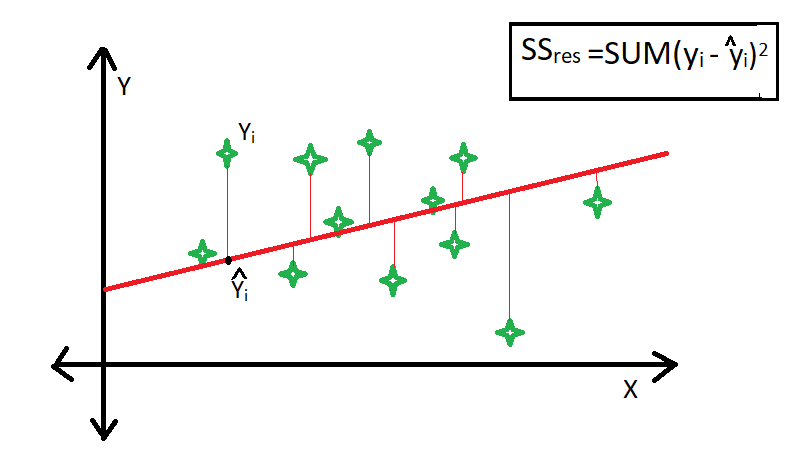

## Obliczenie parametru R2

In [35]:
(y_exp - y_pred_AB).pow(2).sum()

tensor(18.1935)